In [1]:
## 1- Preparacion de los datos

import pandas as pd

# 1.1- Carga desde fichero y mostrar estadisticas
X = pd.read_csv('./dataset_churn_all.csv', index_col=0)

# Valores vacios se inicializan a 0.0 si se deciden incluirse. Leer REAMDE.md
#X['TotalCharges'].replace([' '],[0.0], inplace=True) 
X['Churn'].replace(['No','Yes'],[0,1], inplace=True)

# Valores vacios se eliminan, leer README.md
X = X.loc[(X['TotalCharges']!=' ')]

#Se muestran principales estadigrafos del modelo
print(X.describe())

       SeniorCitizen       tenure  MonthlyCharges        Churn
count    7032.000000  7032.000000     7032.000000  7032.000000
mean        0.162400    32.421786       64.798208     0.265785
std         0.368844    24.545260       30.085974     0.441782
min         0.000000     1.000000       18.250000     0.000000
25%         0.000000     9.000000       35.587500     0.000000
50%         0.000000    29.000000       70.350000     0.000000
75%         0.000000    55.000000       89.862500     1.000000
max         1.000000    72.000000      118.750000     1.000000


In [2]:
# 1.2 - Transformar variables tipo categorica a numericas

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
X['gender'] = le.fit_transform(X['gender'])
X['Partner'] = le.fit_transform(X['Partner'])
X['Dependents'] = le.fit_transform(X['Dependents'])
X['PhoneService'] = le.fit_transform(X['PhoneService'])
X['MultipleLines'] = le.fit_transform(X['MultipleLines'])
X['InternetService'] = le.fit_transform(X['InternetService'])
X['OnlineSecurity'] = le.fit_transform(X['OnlineSecurity'])
X['OnlineBackup'] = le.fit_transform(X['OnlineBackup'])
X['DeviceProtection'] = le.fit_transform(X['DeviceProtection'])
X['TechSupport'] = le.fit_transform(X['TechSupport'])
X['StreamingTV'] = le.fit_transform(X['StreamingTV'])
X['StreamingMovies'] = le.fit_transform(X['StreamingMovies'])
X['Contract'] = le.fit_transform(X['Contract'])
X['PaperlessBilling'] = le.fit_transform(X['PaperlessBilling'])
X['PaymentMethod'] = le.fit_transform(X['PaymentMethod'])

In [3]:
# 2- Dividir la muestra en entrenamiento con 90% y prueba 10%

X1 = X.iloc[:int(len(X)*0.9)]
X2 = X.iloc[int(len(X)*0.1)*-1:]
X_train = X1.drop(['Churn'], axis=1)
X_test  = X2.drop(['Churn'], axis=1)

y_train = X1['Churn']
y_test  = X2['Churn']

In [4]:
# 3- Se selecciona algoritmo MLPClassifier
#    Optimizar rendimiento del modelo
#    Buscar los parametros optimos con GridSearchCV, 
#    Utilizando validacion cruzada, para mejor generalizacion del modelo, 
#    evitando el sobre ajuste y favoreciendo la clase minoritaria 'Yes' que es la
#    que nos interesa.

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import make_scorer, f1_score

model = MLPClassifier(random_state=42)

pipeline = Pipeline([('mlp',  model),])

# Parametros del espacio de busqueda asociado a RandomForest
parameters = {
	'mlp__hidden_layer_sizes': (50,100),
	'mlp__activation': ('relu',),
	'mlp__solver': ('adam','sgd'),	
}

# Metricas de precision a utilizar para la optimizacion de los parametros
scorers = {
    #'f1': make_scorer(f1_score, labels= ('No', 'Yes'), pos_label ='Yes')   
    'f1': make_scorer(f1_score)   
 }

# Buscar mejor ajuste
grid_search = GridSearchCV(pipeline, parameters,  n_jobs=-1, verbose=1, scoring=scorers['f1'], 
	   error_score='raise', cv=7)
grid_search.fit(X_train, y_train)	

Fitting 7 folds for each of 4 candidates, totalling 28 fits


GridSearchCV(cv=7, error_score='raise',
             estimator=Pipeline(steps=[('mlp',
                                        MLPClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'mlp__activation': ('relu',),
                         'mlp__hidden_layer_sizes': (50, 100),
                         'mlp__solver': ('adam', 'sgd')},
             scoring=make_scorer(f1_score), verbose=1)

In [5]:
# Mostrar los parametros optimos del modelo
print("Mejor score: %0.3f" % grid_search.best_score_)
print("Mejor conjunto de parametros:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
	print("\t%s: %r" % (param_name, best_parameters[param_name]))


Mejor score: 0.557
Mejor conjunto de parametros:
	mlp__activation: 'relu'
	mlp__hidden_layer_sizes: 50
	mlp__solver: 'adam'


In [6]:
#Mostrar el rendimiento del modelo
from sklearn.metrics import classification_report

predictions = grid_search.predict(X_test)
print(classification_report(y_test, predictions, digits=4))
#print(classification_report(y_test, predictions, target_names=('No', 'Yes',), labels=('No', 'Yes',), digits=4))

              precision    recall  f1-score   support

           0     0.8154    0.9390    0.8728       508
           1     0.7373    0.4462    0.5559       195

    accuracy                         0.8023       703
   macro avg     0.7763    0.6926    0.7144       703
weighted avg     0.7937    0.8023    0.7849       703



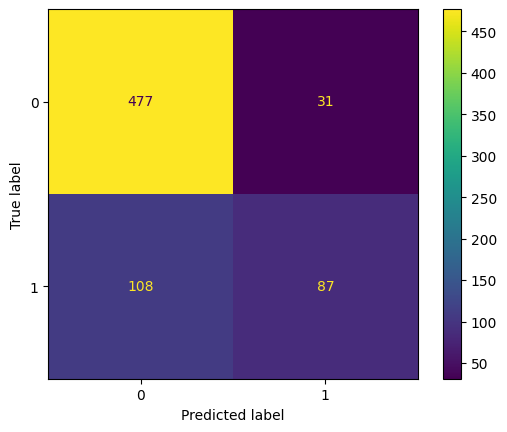

In [7]:
#Mostrar matrix de confusion
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay.from_predictions(y_test, predictions)

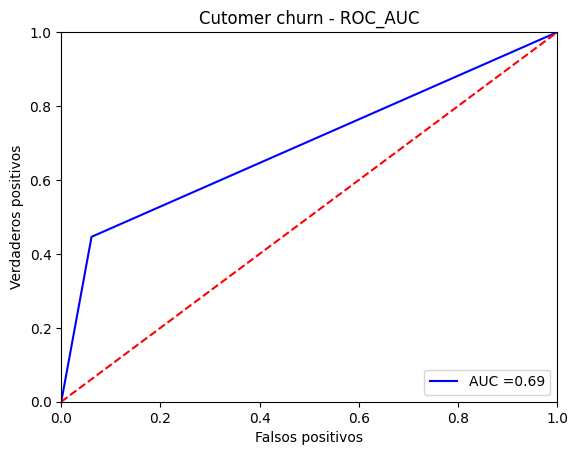

In [8]:
#Calcular la curba ROC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
best_model = grid_search.best_estimator_
fpr, tpr, thresholds = roc_curve(y_test, predictions)
roc_auc = auc(fpr,tpr)
figura = plt.figure()
plt.title('Cutomer churn - ROC_AUC')
plt.plot(fpr,tpr,'b', label='AUC =%0.2f' % roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1], [0,1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.ylabel('Verdaderos positivos')
plt.xlabel('Falsos positivos')
disp1 = plt.show()